# Logistic Regression

## Introduction

Logistic regression is a fundamental algorithm in machine learning used for binary classification problems. Despite its name, logistic regression is a classification algorithm, not a regression algorithm. It models the probability that a given input belongs to a certain class.

The logistic regression model uses the logistic function (also called the sigmoid function) to transform a linear combination of features into a value between 0 and 1, which can be interpreted as a probability.

The logistic function is defined as:

$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n)}}$$

Where:
- $P(y=1|x)$ is the probability that the output is 1 (positive class) given the input features $x$
- $\beta_0$ is the intercept
- $\beta_i$ are the coefficients for each feature $x_i$

Logistic regression fits these coefficients by maximizing the likelihood of the observed data using techniques like gradient descent.

In this notebook, we'll explore logistic regression using the Breast Cancer Wisconsin dataset, which involves classifying tumors as malignant or benign based on various features.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
import joblib
import warnings

# Set up visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')
sns.set_palette('Set2')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration

Let's load the Breast Cancer Wisconsin dataset and explore its structure.

In [2]:
# Load the Breast Cancer Wisconsin dataset
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

# Display information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Target classes: {cancer.target_names}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class proportions: {np.bincount(y) / len(y)}")

Dataset shape: (569, 30)
Number of features: 30
Target classes: ['malignant' 'benign']
Class distribution: [212 357]
Class proportions: [0.37258348 0.62741652]


In [3]:
# Display dataset description
print(cancer.DESCR[:1000] + "...")

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [4]:
# Display the first few rows of the dataset
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Get statistical summary of the dataset
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [6]:
# Check for missing values
print("Missing values in each column:")
X.isnull().sum()

Missing values in each column:


mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

## 2. Exploratory Data Analysis (EDA)

Let's visualize the data to understand the relationships between features and the target variable.

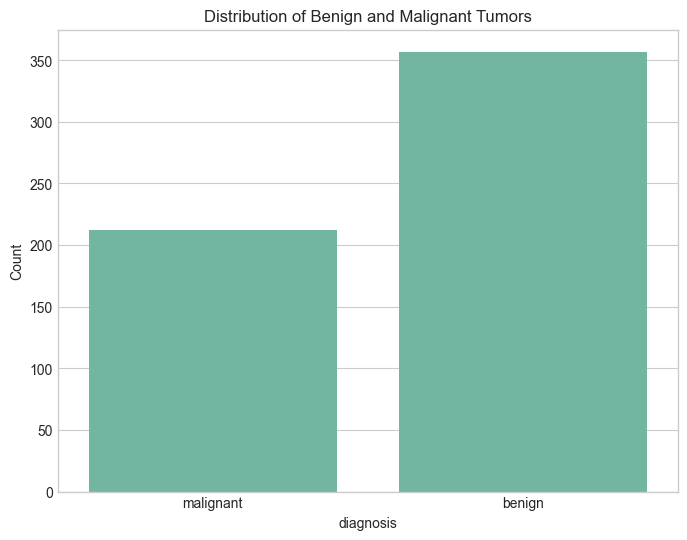

In [7]:
# Create a DataFrame that includes the target variable
df = X.copy()
df['target'] = y
df['diagnosis'] = [cancer.target_names[i] for i in y]

# Plot the distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=df)
plt.title('Distribution of Benign and Malignant Tumors')
plt.ylabel('Count')
plt.show()

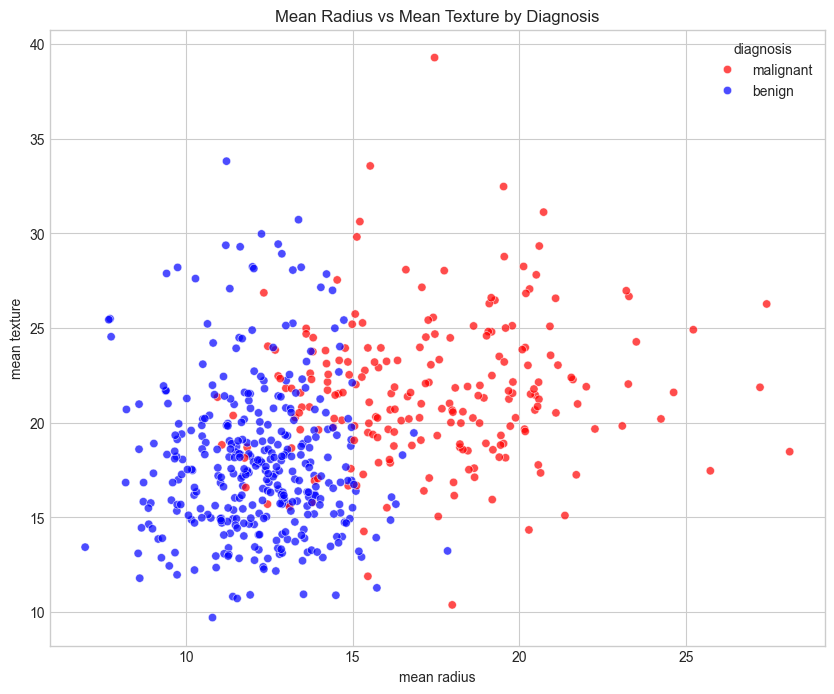

In [8]:
# Scatter plot of two selected features, colored by diagnosis
plt.figure(figsize=(10, 8))
sns.scatterplot(x='mean radius', y='mean texture', hue='diagnosis', data=df, palette={'malignant': 'red', 'benign': 'blue'}, alpha=0.7)
plt.title('Mean Radius vs Mean Texture by Diagnosis')
plt.show()

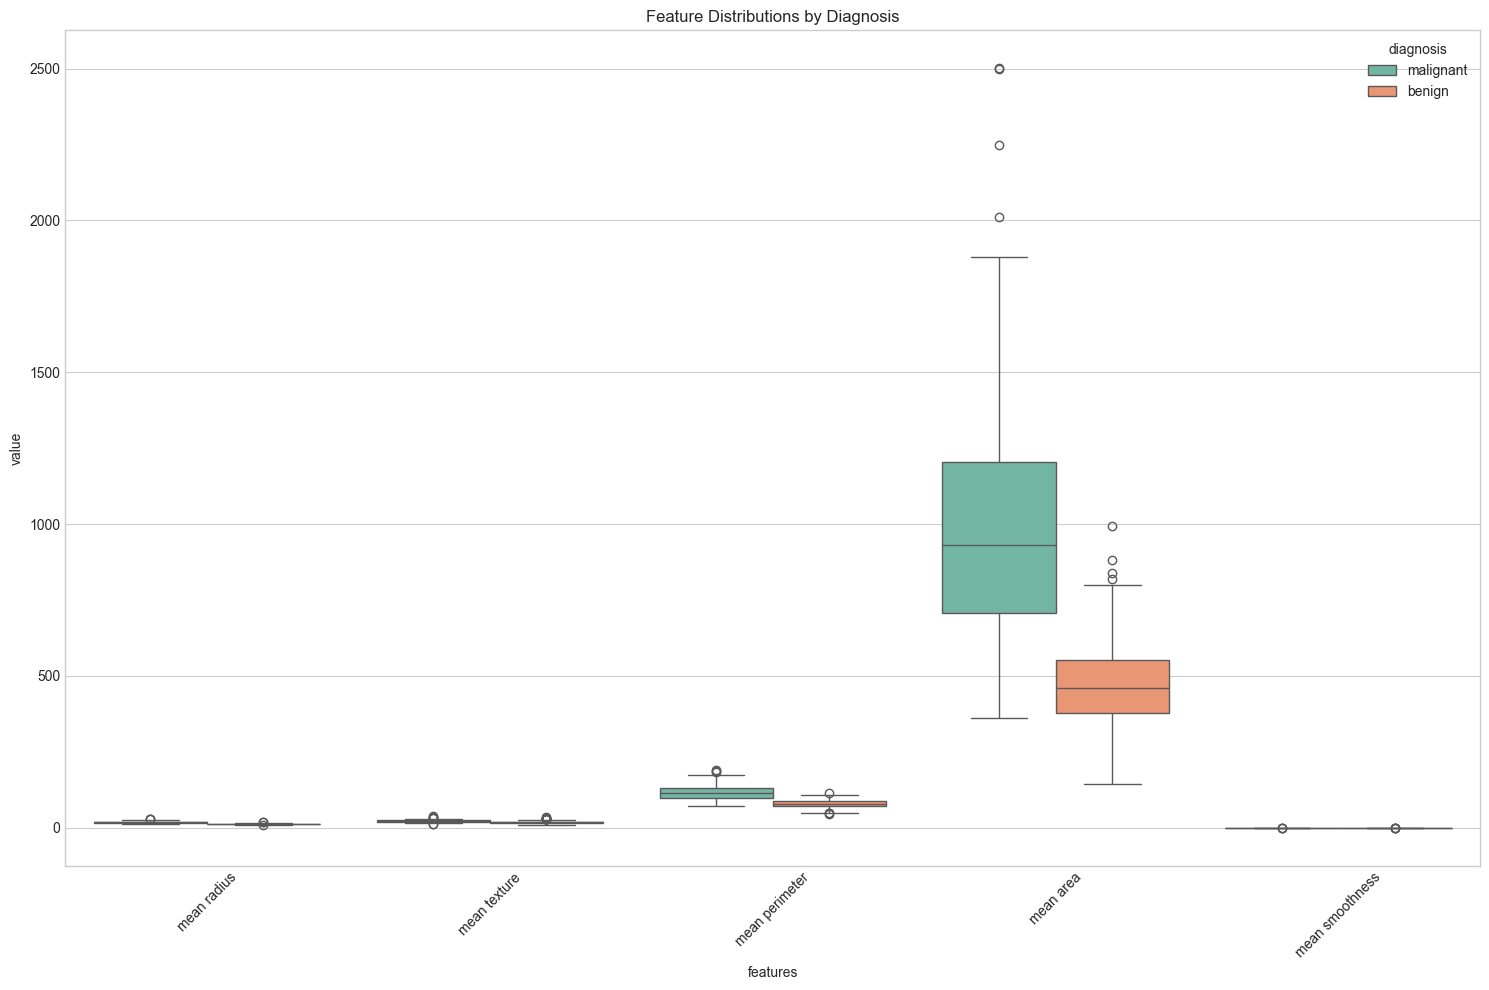

In [9]:
# Box plots to compare feature distributions by diagnosis
plt.figure(figsize=(15, 10))
top_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
melted_df = pd.melt(df[top_features + ['diagnosis']], id_vars='diagnosis', var_name='features', value_name='value')
sns.boxplot(x='features', y='value', hue='diagnosis', data=melted_df)
plt.title('Feature Distributions by Diagnosis')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

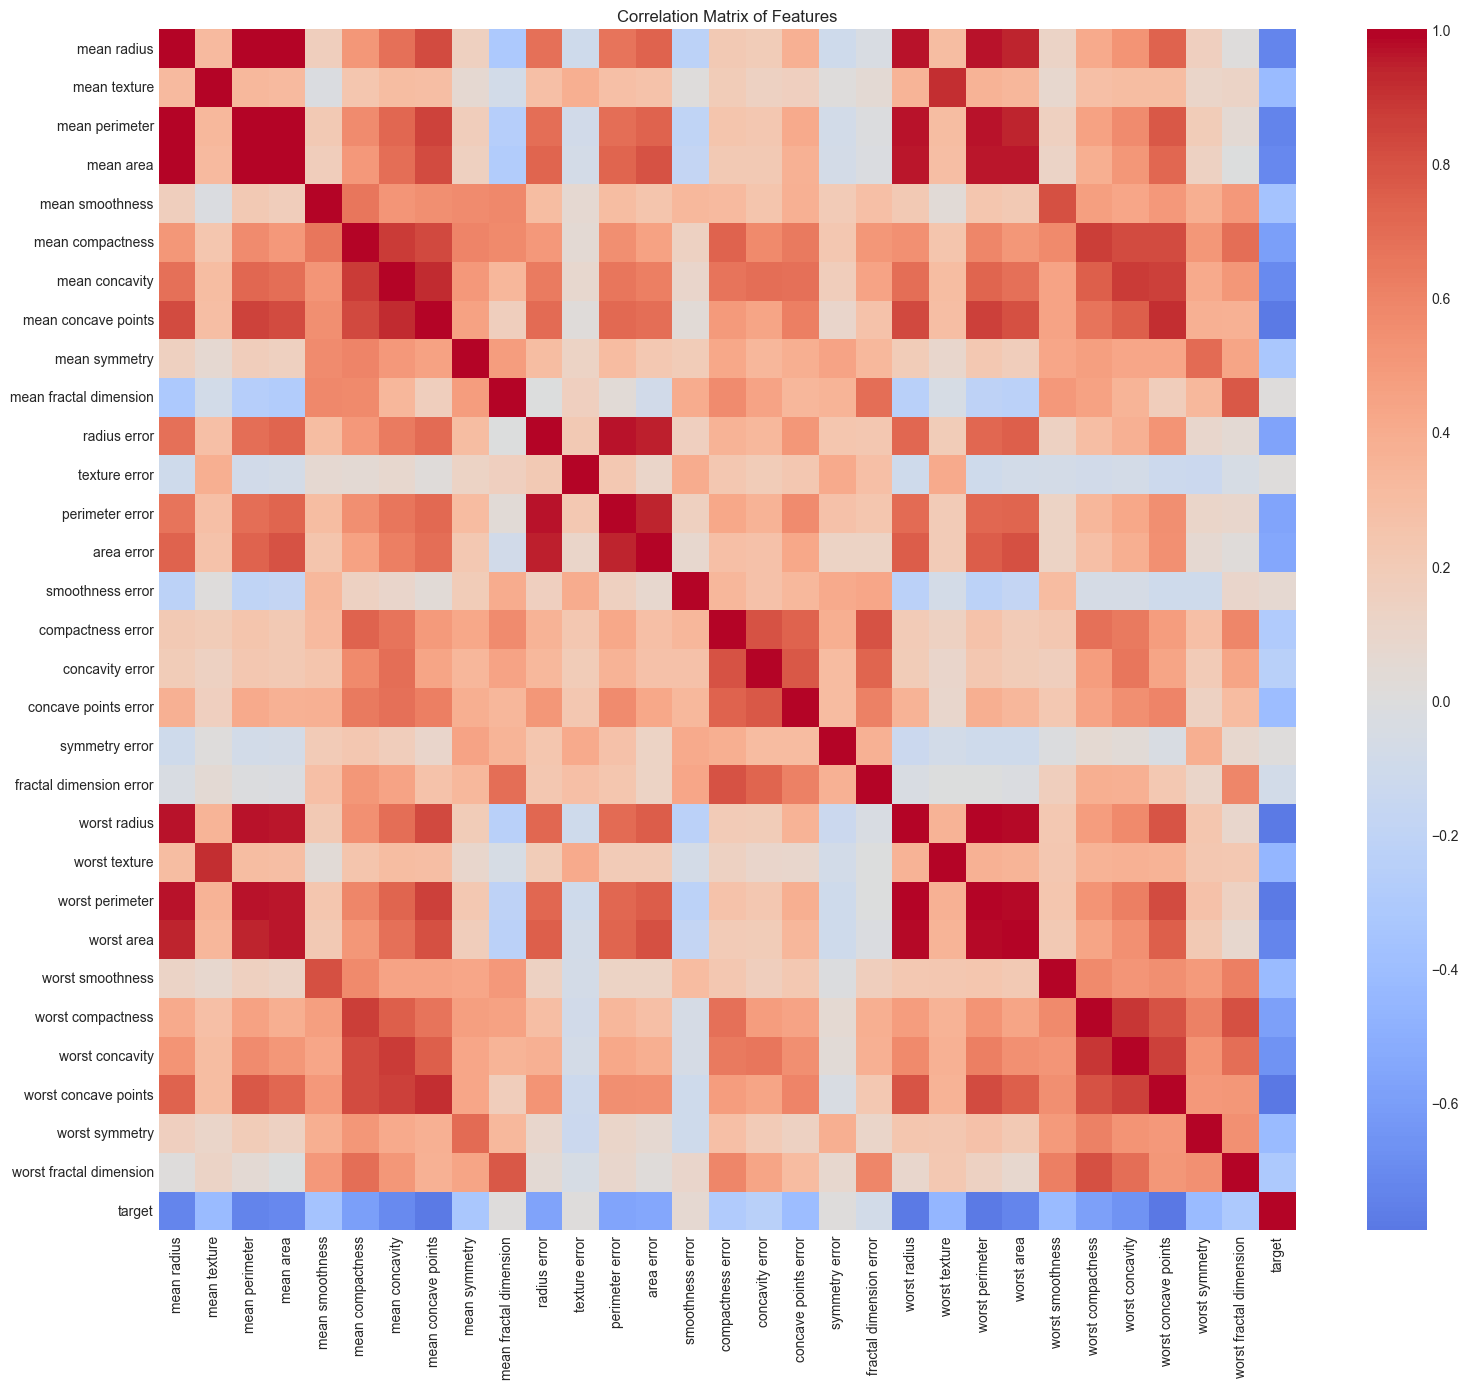

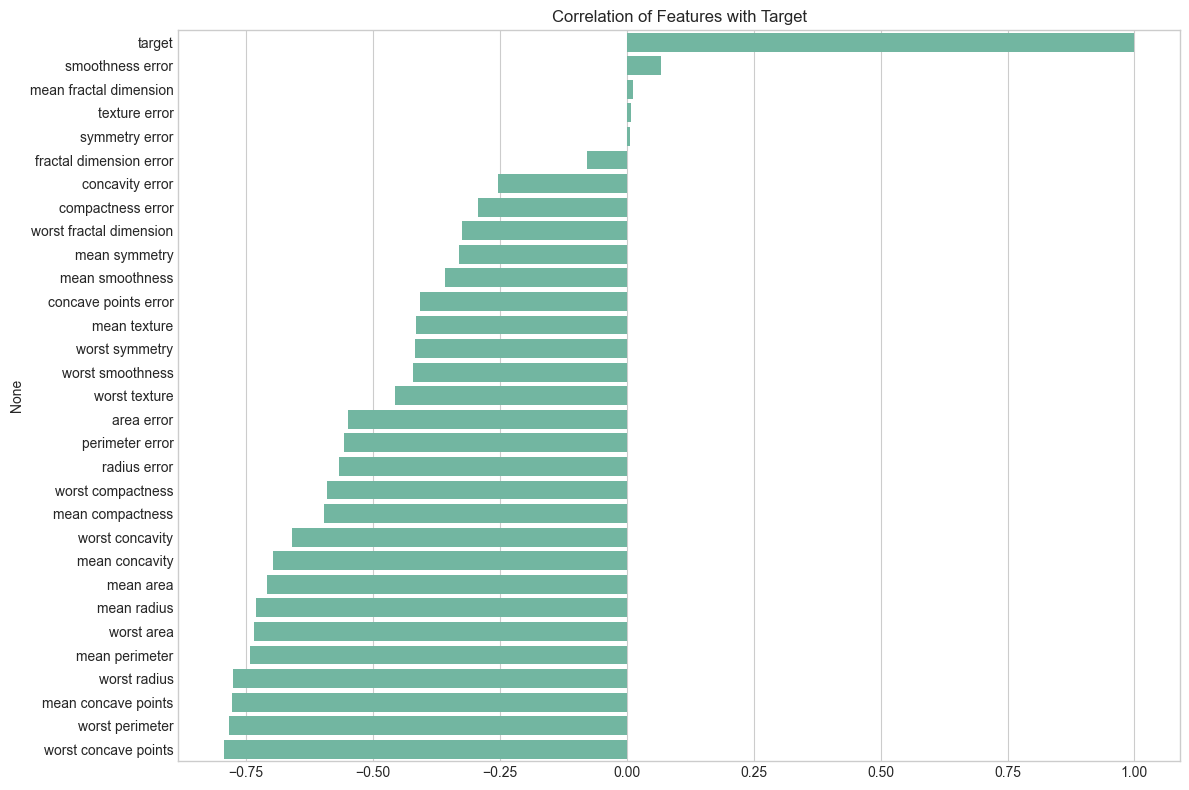

In [10]:
# Correlation matrix and heatmap
correlation_matrix = df.drop(['diagnosis'], axis=1).corr().round(2)
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlation with target
target_corr = df.drop(['diagnosis'], axis=1).corrwith(df['target']).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation of Features with Target')
plt.tight_layout()
plt.show()

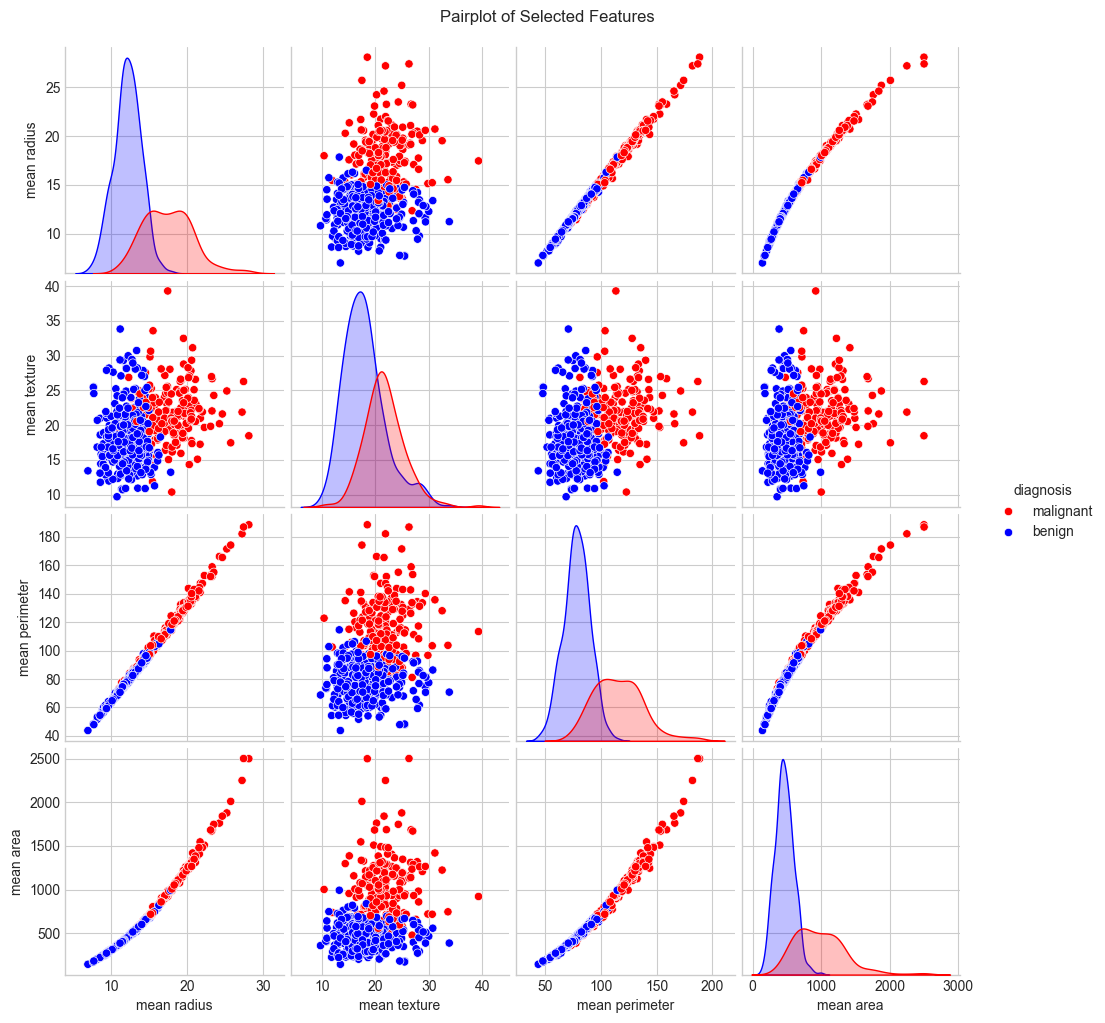

In [11]:
# Pairplot for selected features
sns.pairplot(df[['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'diagnosis']], 
             hue='diagnosis', palette={'malignant': 'red', 'benign': 'blue'}, height=2.5)
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

## 3. Data Preprocessing

Let's prepare the data for model training by splitting it into training and testing sets, and scaling the features.

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set shape: (455, 30)
Testing set shape: (114, 30)
Training set class distribution: [170 285]
Testing set class distribution: [42 72]


In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for better interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print("First 5 rows of scaled training data:")
X_train_scaled_df.head()

First 5 rows of scaled training data:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,...,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
1,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,...,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
2,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,...,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
3,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,...,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
4,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,...,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639


## 4. Model Building: Basic Logistic Regression

Let's start with a basic logistic regression model.

In [14]:
# Initialize and train the basic logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get probability predictions
y_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Testing Precision: {test_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Testing Recall: {test_recall:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Testing F1 Score: {test_f1:.4f}")
print(f"Training ROC AUC: {train_roc_auc:.4f}")
print(f"Testing ROC AUC: {test_roc_auc:.4f}")

Training Accuracy: 0.9890
Testing Accuracy: 0.9825
Training Precision: 0.9861
Testing Precision: 0.9861
Training Recall: 0.9965
Testing Recall: 0.9861
Training F1 Score: 0.9913
Testing F1 Score: 0.9861
Training ROC AUC: 0.9975
Testing ROC AUC: 0.9954


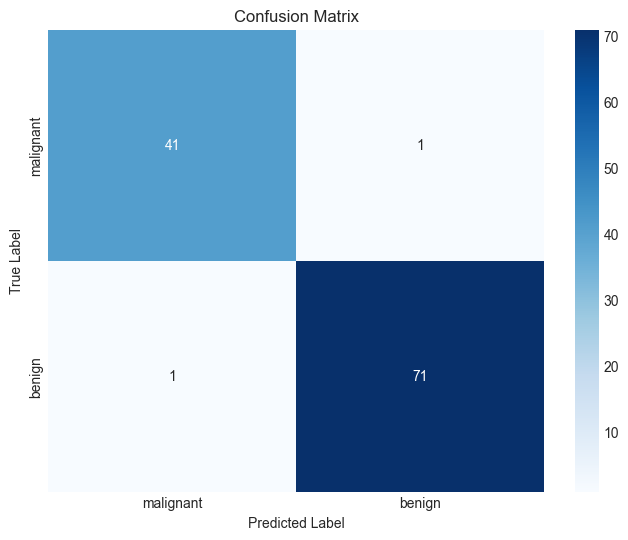

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [15]:
# Confusion Matrix
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=cancer.target_names))

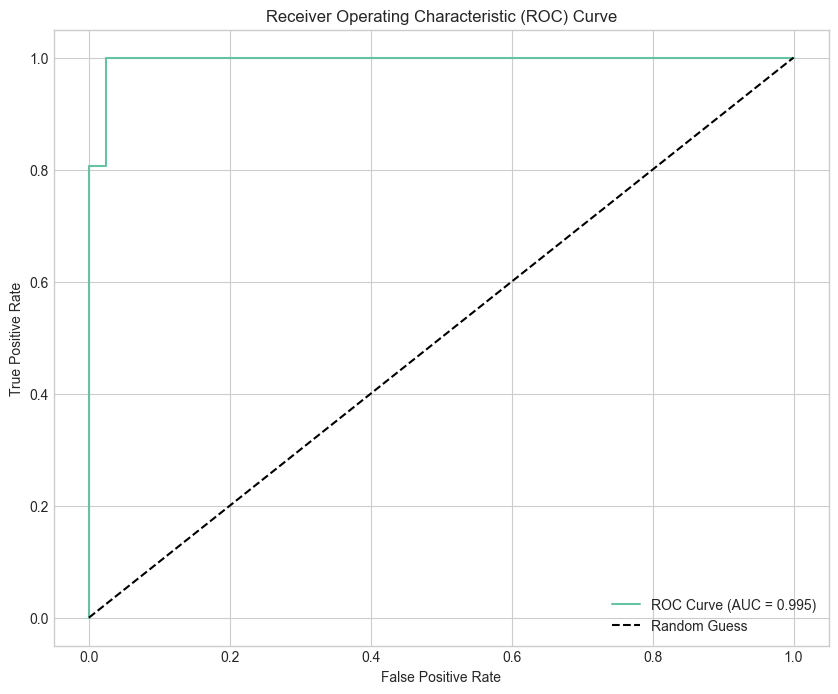

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

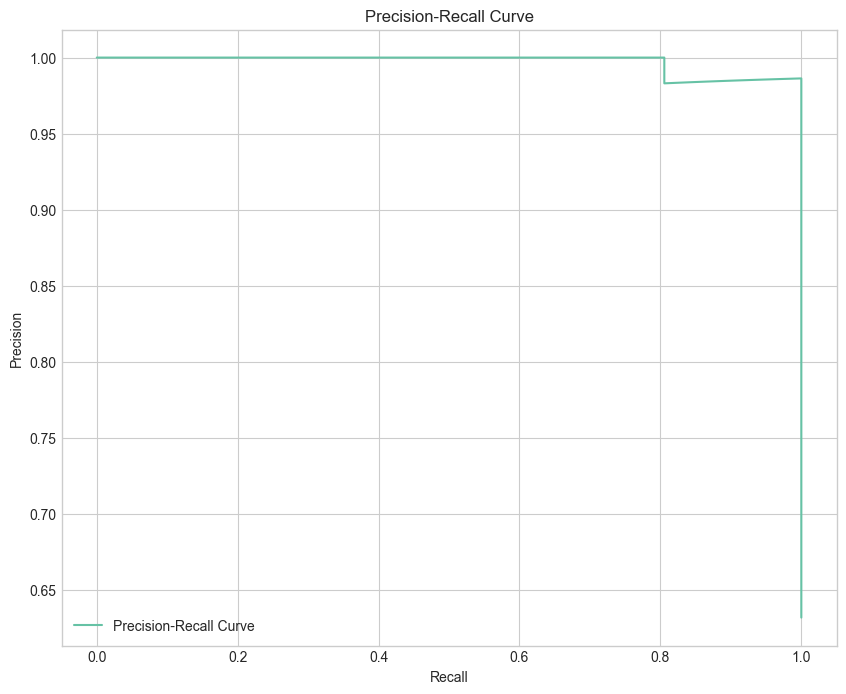

In [17]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

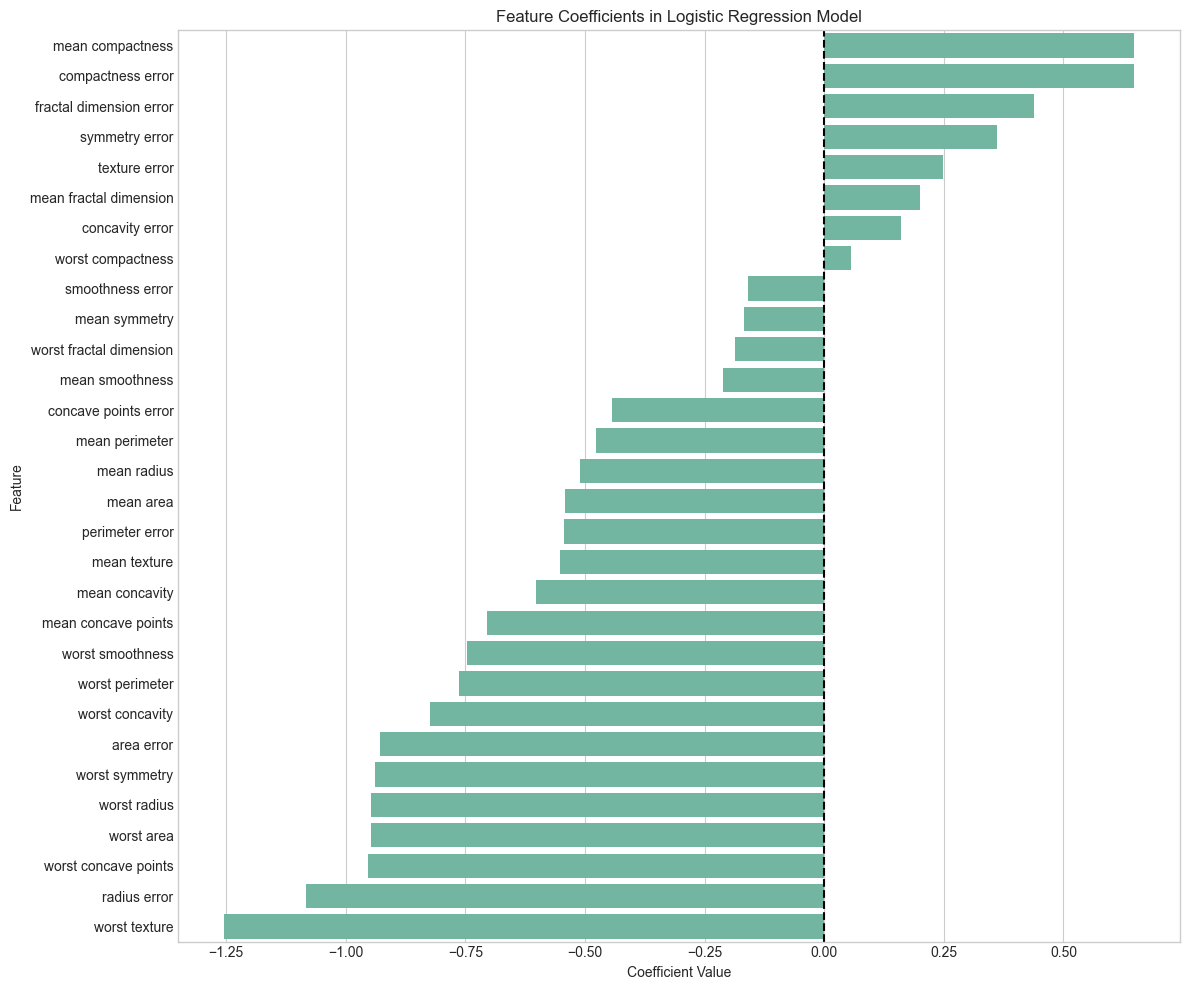

In [18]:
# Model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Coefficients in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

## 5. Model Improvement: Regularized Logistic Regression

Let's try different regularization techniques (L1, L2, Elastic Net) to improve our model performance and interpretability.

In [19]:
# Create a pipeline with feature scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

# Define parameters for grid search
param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logreg__l1_ratio': [0.0, 0.2, 0.5, 0.8, 1.0]
}

# Not all combinations are valid, so we need to define a custom param_grid
param_grid_valid = [
    # L1 penalty
    {'logreg__penalty': ['l1'], 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logreg__solver': ['liblinear', 'saga']},
    # L2 penalty
    {'logreg__penalty': ['l2'], 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
    # Elastic Net
    {'logreg__penalty': ['elasticnet'], 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logreg__l1_ratio': [0.2, 0.5, 0.8], 'logreg__solver': ['saga']},
    # No penalty
    {'logreg__penalty': ['none'], 'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid_valid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

# Best model
best_model = grid_search.best_estimator_

Best parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validation ROC AUC: 0.9941


In [20]:
# Make predictions with the best model
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)
y_train_proba_best = best_model.predict_proba(X_train)[:, 1]
y_test_proba_best = best_model.predict_proba(X_test)[:, 1]

# Evaluate the best model
best_train_accuracy = accuracy_score(y_train, y_train_pred_best)
best_test_accuracy = accuracy_score(y_test, y_test_pred_best)
best_train_precision = precision_score(y_train, y_train_pred_best)
best_test_precision = precision_score(y_test, y_test_pred_best)
best_train_recall = recall_score(y_train, y_train_pred_best)
best_test_recall = recall_score(y_test, y_test_pred_best)
best_train_f1 = f1_score(y_train, y_train_pred_best)
best_test_f1 = f1_score(y_test, y_test_pred_best)
best_train_roc_auc = roc_auc_score(y_train, y_train_proba_best)
best_test_roc_auc = roc_auc_score(y_test, y_test_proba_best)

print(f"Best Model Training Accuracy: {best_train_accuracy:.4f}")
print(f"Best Model Testing Accuracy: {best_test_accuracy:.4f}")
print(f"Best Model Training Precision: {best_train_precision:.4f}")
print(f"Best Model Testing Precision: {best_test_precision:.4f}")
print(f"Best Model Training Recall: {best_train_recall:.4f}")
print(f"Best Model Testing Recall: {best_test_recall:.4f}")
print(f"Best Model Training F1 Score: {best_train_f1:.4f}")
print(f"Best Model Testing F1 Score: {best_test_f1:.4f}")
print(f"Best Model Training ROC AUC: {best_train_roc_auc:.4f}")
print(f"Best Model Testing ROC AUC: {best_test_roc_auc:.4f}")

Best Model Training Accuracy: 0.9868
Best Model Testing Accuracy: 0.9825
Best Model Training Precision: 0.9827
Best Model Testing Precision: 0.9861
Best Model Training Recall: 0.9965
Best Model Testing Recall: 0.9861
Best Model Training F1 Score: 0.9895
Best Model Testing F1 Score: 0.9861
Best Model Training ROC AUC: 0.9965
Best Model Testing ROC AUC: 0.9960


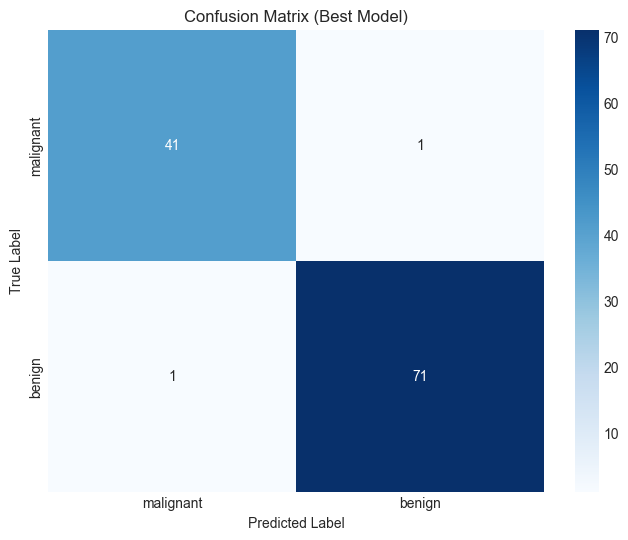

Classification Report (Best Model):
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [21]:
# Confusion Matrix for best model
best_test_cm = confusion_matrix(y_test, y_test_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(best_test_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report for best model
print("Classification Report (Best Model):")
print(classification_report(y_test, y_test_pred_best, target_names=cancer.target_names))

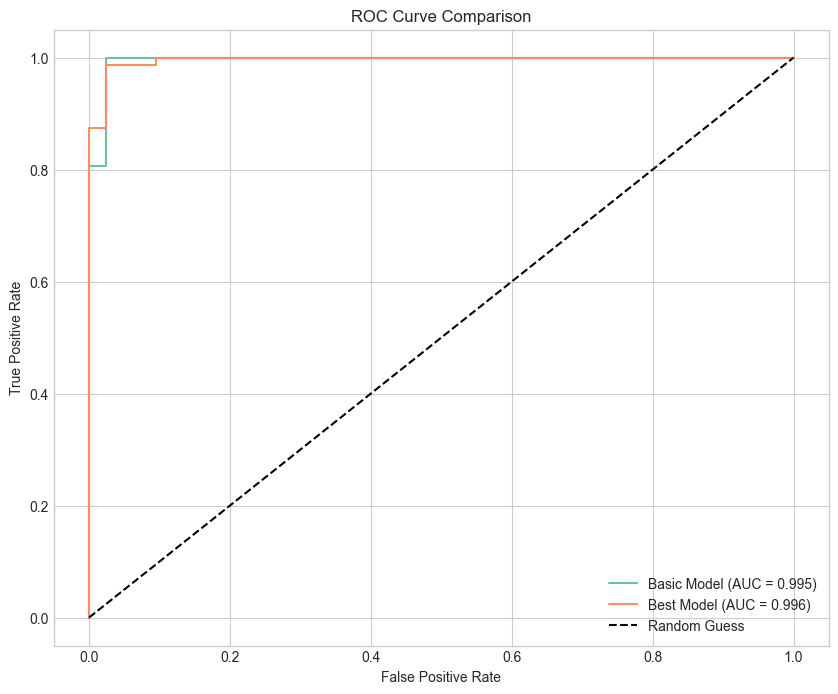

In [22]:
# ROC Curve for best model
best_fpr, best_tpr, best_thresholds = roc_curve(y_test, y_test_proba_best)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Basic Model (AUC = {test_roc_auc:.3f})')
plt.plot(best_fpr, best_tpr, label=f'Best Model (AUC = {best_test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

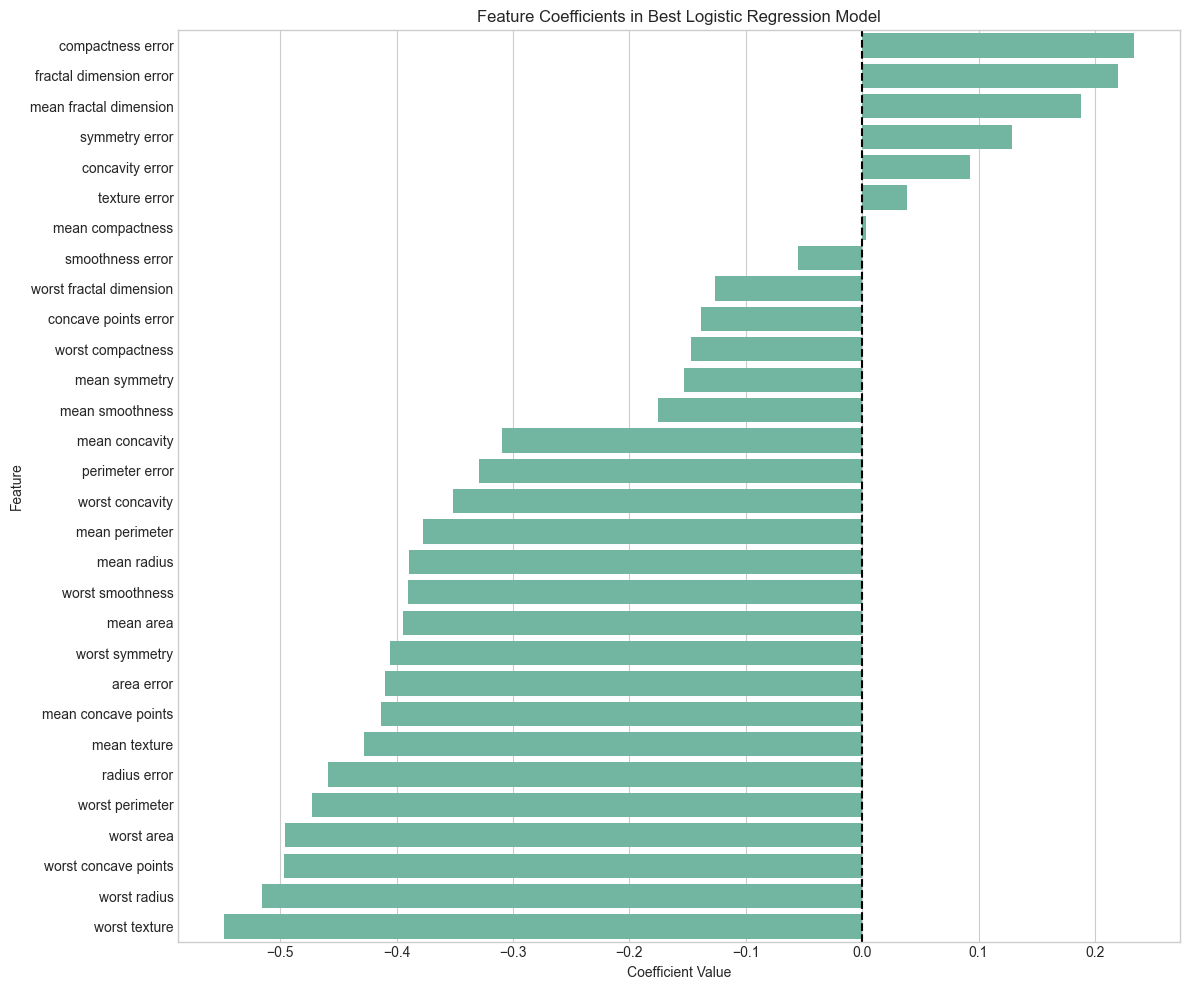

In [23]:
# Get the coefficients from the best model
best_logreg = best_model.named_steps['logreg']
best_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Coefficient', y='Feature', data=best_coefficients)
plt.title('Feature Coefficients in Best Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

## 6. Feature Selection

Let's perform feature selection to identify the most important features for our classification task.

In [24]:
# Feature selection using SelectKBest
feature_selector = SelectKBest(f_classif, k=10)
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_test_selected = feature_selector.transform(X_test)

# Get the selected feature names
selected_feature_mask = feature_selector.get_support()
selected_features = X.columns[selected_feature_mask]
print(f"Selected features: {selected_features.tolist()}")

# Train a logistic regression model on the selected features
selected_model = LogisticRegression(random_state=42)
selected_model.fit(X_train_selected, y_train)
y_train_pred_selected = selected_model.predict(X_train_selected)
y_test_pred_selected = selected_model.predict(X_test_selected)
y_train_proba_selected = selected_model.predict_proba(X_train_selected)[:, 1]
y_test_proba_selected = selected_model.predict_proba(X_test_selected)[:, 1]

# Evaluate the model with selected features
selected_train_accuracy = accuracy_score(y_train, y_train_pred_selected)
selected_test_accuracy = accuracy_score(y_test, y_test_pred_selected)
selected_train_roc_auc = roc_auc_score(y_train, y_train_proba_selected)
selected_test_roc_auc = roc_auc_score(y_test, y_test_proba_selected)

print(f"Selected Features Training Accuracy: {selected_train_accuracy:.4f}")
print(f"Selected Features Testing Accuracy: {selected_test_accuracy:.4f}")
print(f"Selected Features Training ROC AUC: {selected_train_roc_auc:.4f}")
print(f"Selected Features Testing ROC AUC: {selected_test_roc_auc:.4f}")

Selected features: ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']
Selected Features Training Accuracy: 0.9516
Selected Features Testing Accuracy: 0.9649
Selected Features Training ROC AUC: 0.9853
Selected Features Testing ROC AUC: 0.9878


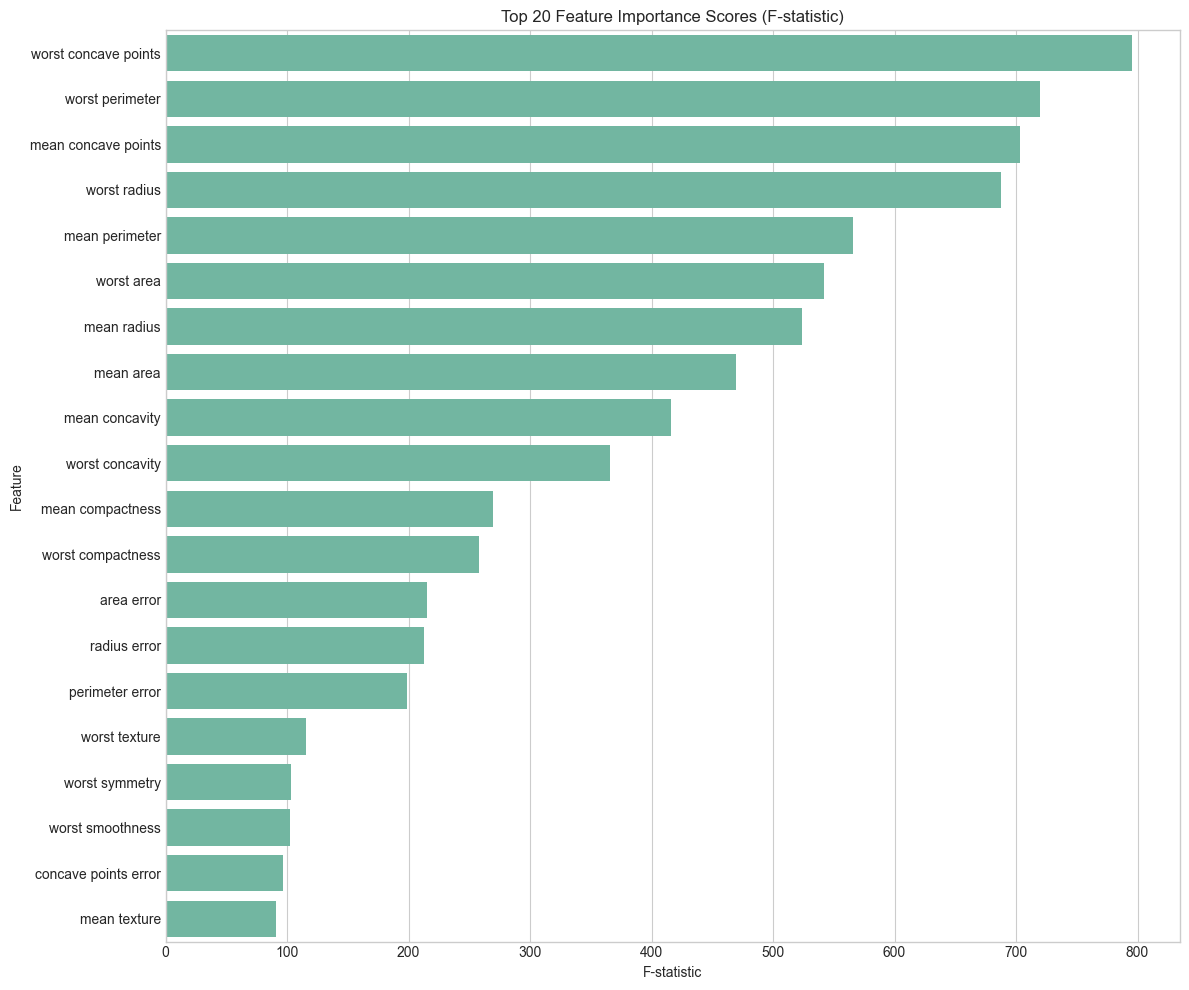

In [25]:
# Plot feature importance scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_selector.scores_
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(20))
plt.title('Top 20 Feature Importance Scores (F-statistic)')
plt.xlabel('F-statistic')
plt.tight_layout()
plt.show()

## 7. Learning Curves and Validation Curves

Learning curves help us understand if our model would benefit from more data or if it's overfitting/underfitting.
Validation curves help us understand the impact of a specific hyperparameter on the model's performance.

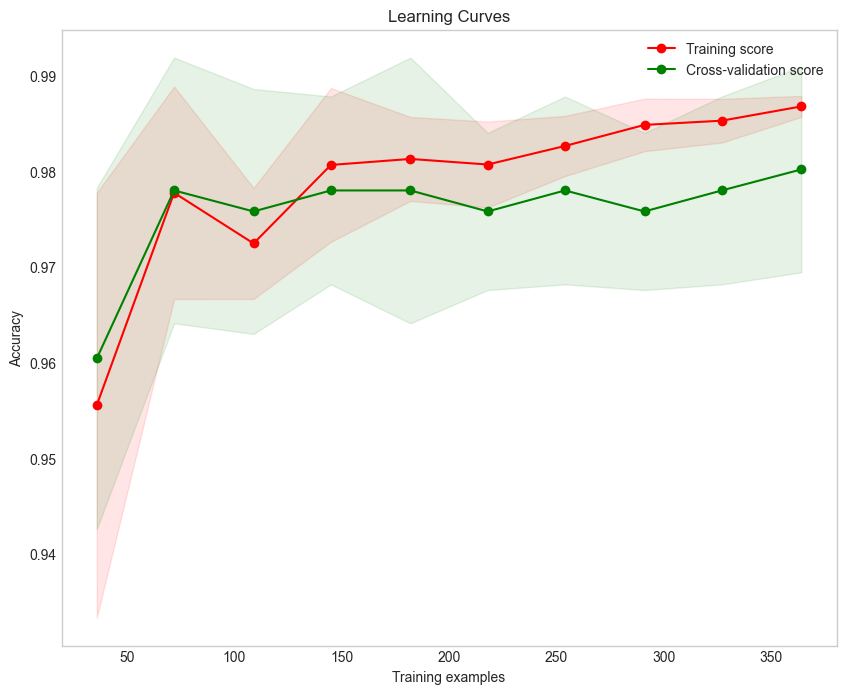

In [26]:
# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

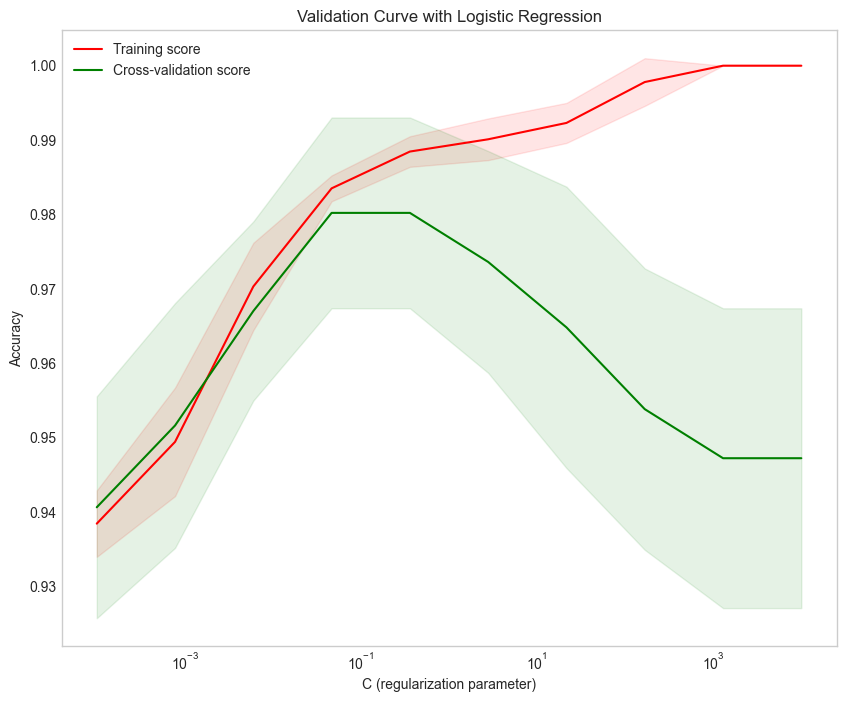

In [27]:
# Validation curve for regularization parameter C
# Create a new pipeline for validation curve
pipeline_vc = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

# Set the best parameters from grid search except for C
pipeline_vc.set_params(**{
    k: v for k, v in grid_search.best_params_.items() if 'C' not in k
})

# Define the range of C values to test
param_range = np.logspace(-4, 4, 10)

# Calculate validation curves
train_scores, test_scores = validation_curve(
    pipeline_vc, X_train, y_train, param_name="logreg__C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(10, 8))
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C (regularization parameter)")
plt.ylabel("Accuracy")
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.legend(loc="best")
plt.grid()
plt.show()

## 8. Decision Boundary Visualization

Let's visualize the decision boundary of our logistic regression model in a 2D space using PCA to reduce the feature dimensionality.

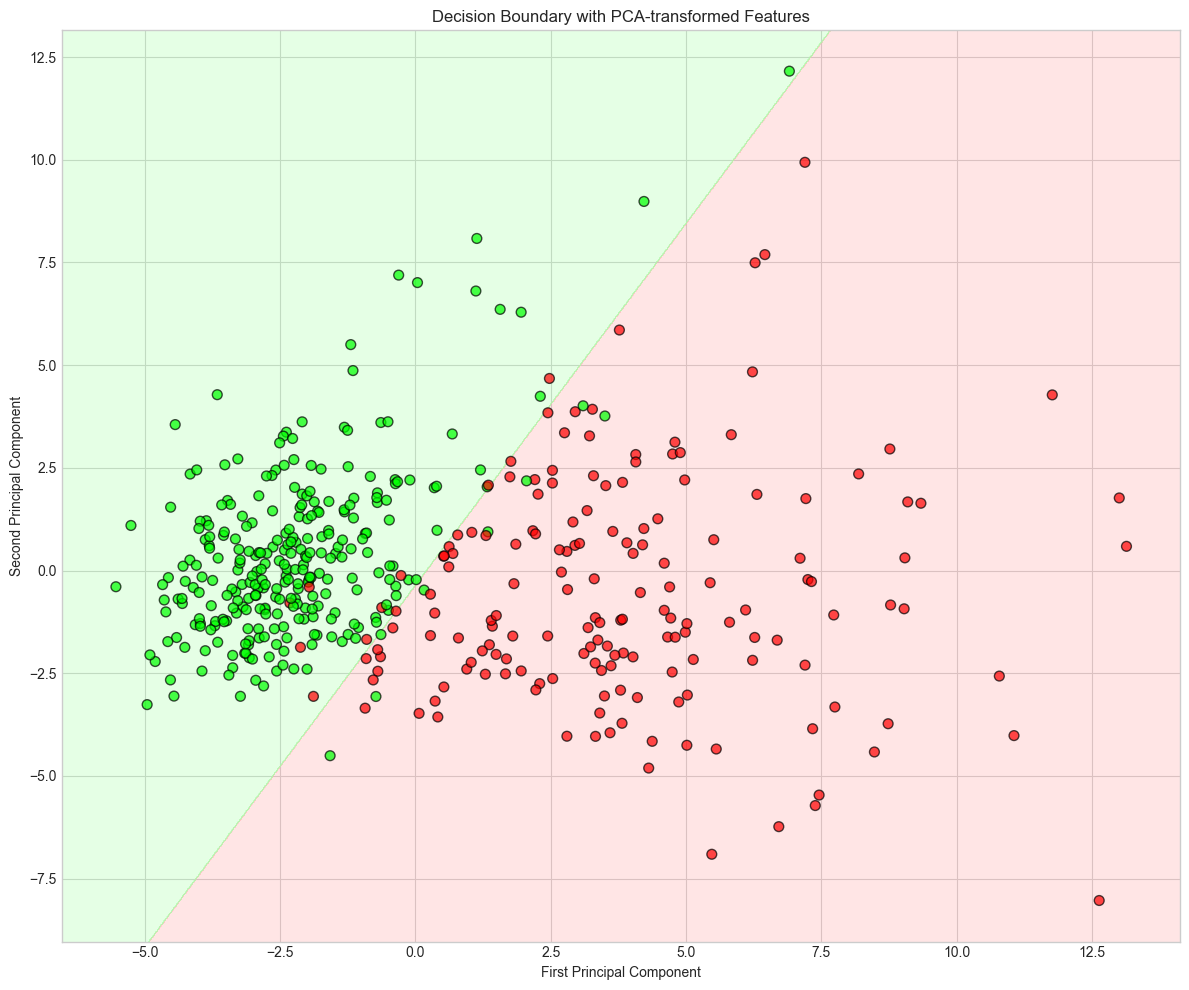

Explained variance ratio: [0.44413492 0.18944618]
Total explained variance: 0.63


In [28]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Apply PCA to reduce the feature space to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a logistic regression model on the PCA-transformed data
lr_pca = LogisticRegression(random_state=42)
lr_pca.fit(X_train_pca, y_train)

# Create a mesh grid to visualize the decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict class labels for the mesh grid points
Z = lr_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define custom colormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Plot the decision boundary and scatter plot of the data
plt.figure(figsize=(12, 10))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=50, alpha=0.7)
plt.title('Decision Boundary with PCA-transformed Features')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

In [29]:
# Print the accuracy on the PCA-transformed data
train_pca_accuracy = accuracy_score(y_train, lr_pca.predict(X_train_pca))
test_pca_accuracy = accuracy_score(y_test, lr_pca.predict(X_test_pca))
print(f"Training accuracy with PCA: {train_pca_accuracy:.4f}")
print(f"Testing accuracy with PCA: {test_pca_accuracy:.4f}")

Training accuracy with PCA: 0.9604
Testing accuracy with PCA: 0.9474


## 9. Model Interpretability

One of the advantages of logistic regression is its interpretability. Let's analyze the coefficients and the odds ratios.

In [30]:
# Get the coefficients from the best model
best_logreg = best_model.named_steps['logreg']
best_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_logreg.coef_[0],
    'Odds Ratio': np.exp(best_logreg.coef_[0])  # Exponentiate coefficients to get odds ratios
}).sort_values(by='Coefficient', ascending=False)

# Display the coefficients and odds ratios
print("Coefficients and Odds Ratios:")
best_coefficients

Coefficients and Odds Ratios:


,Feature,Coefficient,Odds Ratio
15,compactness error,0.234016,1.263664
19,fractal dimension error,0.219744,1.245758
9,mean fractal dimension,0.188464,1.207393
18,symmetry error,0.128409,1.137018
16,concavity error,0.093035,1.097500
11,texture error,0.038866,1.039631
5,mean compactness,0.003244,1.003249
14,smoothness error,-0.055418,0.946089
29,worst fractal dimension,-0.126729,0.880972
17,concave points error,-0.138780,0.870419


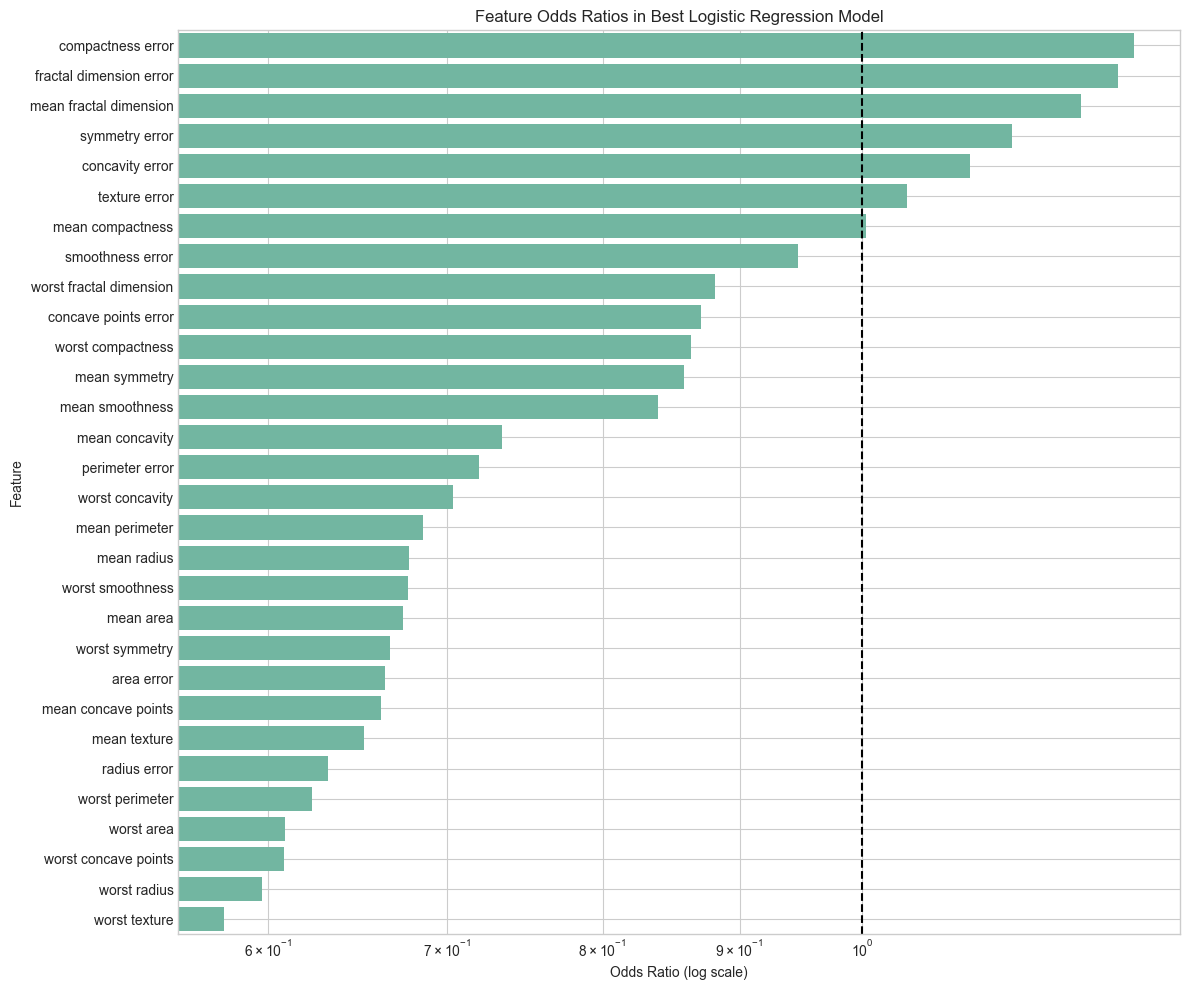

In [31]:
# Plot the odds ratios
plt.figure(figsize=(12, 10))
sns.barplot(x='Odds Ratio', y='Feature', data=best_coefficients)
plt.title('Feature Odds Ratios in Best Logistic Regression Model')
plt.xlabel('Odds Ratio (log scale)')
plt.ylabel('Feature')
plt.axvline(x=1, color='black', linestyle='--')
plt.xscale('log')
plt.grid(True, which="both", ls="-")
plt.tight_layout()
plt.show()

In [32]:
# Explain the interpretation of the model
print("Interpretation of Logistic Regression Coefficients:")
print("\nThe logistic regression model estimates the probability of a tumor being malignant (class 1) given the features.")
print("\nCoefficient Interpretation:")
print("- Positive coefficients: Higher values of these features increase the probability of malignancy.")
print("- Negative coefficients: Higher values of these features decrease the probability of malignancy.")
print("- The magnitude of the coefficient indicates its relative importance.")
print("\nOdds Ratio Interpretation:")
print("- Odds ratio > 1: Feature increases the odds of malignancy.")
print("- Odds ratio < 1: Feature decreases the odds of malignancy.")
print("- The odds ratio tells us how much the odds of malignancy change when the feature increases by one standard deviation.")

# Get the top positive and negative features
top_positive = best_coefficients.nlargest(3, 'Coefficient')
top_negative = best_coefficients.nsmallest(3, 'Coefficient')

print("\nTop 3 Features Increasing Malignancy Probability:")
for idx, row in top_positive.iterrows():
    print(f"- {row['Feature']}: Coefficient = {row['Coefficient']:.4f}, Odds Ratio = {row['Odds Ratio']:.4f}")

print("\nTop 3 Features Decreasing Malignancy Probability:")
for idx, row in top_negative.iterrows():
    print(f"- {row['Feature']}: Coefficient = {row['Coefficient']:.4f}, Odds Ratio = {row['Odds Ratio']:.4f}")

Interpretation of Logistic Regression Coefficients:

The logistic regression model estimates the probability of a tumor being malignant (class 1) given the features.

Coefficient Interpretation:
- Positive coefficients: Higher values of these features increase the probability of malignancy.
- Negative coefficients: Higher values of these features decrease the probability of malignancy.
- The magnitude of the coefficient indicates its relative importance.

Odds Ratio Interpretation:
- Odds ratio > 1: Feature increases the odds of malignancy.
- Odds ratio < 1: Feature decreases the odds of malignancy.
- The odds ratio tells us how much the odds of malignancy change when the feature increases by one standard deviation.

Top 3 Features Increasing Malignancy Probability:
- compactness error: Coefficient = 0.2340, Odds Ratio = 1.2637
- fractal dimension error: Coefficient = 0.2197, Odds Ratio = 1.2458
- mean fractal dimension: Coefficient = 0.1885, Odds Ratio = 1.2074

Top 3 Features Decreas

## 10. Final Model and Serialization

Let's finalize our model by retraining it on the entire dataset and save it for later use.

In [33]:
# Create and train the final model on all data
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(**{k.replace('logreg__', ''): v for k, v in grid_search.best_params_.items() if 'logreg__' in k}, random_state=42))
])

final_model.fit(X, y)

# Save the model
import os

# Create directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(final_model, 'models/logistic_regression_model.pkl')
print("Model saved to 'models/logistic_regression_model.pkl'")

Model saved to 'models/logistic_regression_model.pkl'


In [34]:
# Test loading the model
loaded_model = joblib.load('models/logistic_regression_model.pkl')
loaded_predictions = loaded_model.predict(X_test)
loaded_accuracy = accuracy_score(y_test, loaded_predictions)
print(f"Loaded model accuracy: {loaded_accuracy:.4f}")

Loaded model accuracy: 0.9825


In [37]:
# Make a single prediction to demonstrate how to use the model
sample_data = X_test.iloc[0:1]
print("Sample data:")
print(sample_data)

prediction = loaded_model.predict(sample_data)[0]
prediction_probability = loaded_model.predict_proba(sample_data)[0, 1]
print(f"\nPredicted class: {prediction} ({cancer.target_names[prediction]})")
print(f"Probability of being malignant: {prediction_probability:.4f}")

Sample data:
     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
256        19.55         28.77           133.6     1207.0           0.0926   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
256            0.2063          0.1784               0.1144         0.1893   

     mean fractal dimension  ...  worst radius  worst texture  \
256                 0.06232  ...         25.05          36.27   

     worst perimeter  worst area  worst smoothness  worst compactness  \
256            178.6      1926.0            0.1281             0.5329   

     worst concavity  worst concave points  worst symmetry  \
256           0.4251                0.1941          0.2818   

     worst fractal dimension  
256                   0.1005  

[1 rows x 30 columns]

Predicted class: 0 (malignant)
Probability of being malignant: 0.0000
